# Face Recognition

In [1]:
%matplotlib inline

import sys
sys.path.append('/homes/yz4009/wd/gitdev/TFNet/')
import utils
import visualise
from networks import recognition

/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/vol/atlas/homes/yz4009/gitdev/menpofit/menpofit/math/fft_utils.py:20: RuntimeWarning: pyfftw is known to be buggy on your system, numpy.fft will be used instead. Consequently, all algorithms using ffts will be running at a slower speed.
  RuntimeWarning)


In [2]:
import tensorflow as tf
import data_provider
import menpo.io as mio
import scipy.io as sio
import os
import menpo
import scipy
import models
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from menpo.visualize import print_progress
from scipy.sparse import csr_matrix
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud, PointUndirectedGraph
from menpowidgets import visualize_images
from sklearn.metrics import classification_report, accuracy_score
np.set_printoptions(3)
slim = tf.contrib.slim

In [3]:

"""Validate a face recognizer on the "Labeled Faces in the Wild" dataset (http://vis-www.cs.umass.edu/lfw/).
Embeddings are calculated using the pairs from http://vis-www.cs.umass.edu/lfw/pairs.txt and the ROC curve
is calculated and plotted. Both the model metagraph and the model parameters need to exist
in the same directory, and the metagraph should have the extension '.meta'.
"""
# MIT License
#
# Copyright (c) 2016 David Sandberg
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import argparse
import os
import sys
import re
import math
from scipy import misc
from sklearn.model_selection import KFold

from sklearn import metrics
from scipy.optimize import brentq
from scipy import interpolate
import tensorflow.contrib.slim as slim

In [4]:


def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs)

def get_paths(lfw_dir, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])+'.'+file_ext)
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])+'.'+file_ext)
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list


def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model_dir, meta_file, ckpt_file):
    model_dir_exp = os.path.expanduser(model_dir)
    saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
    saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
    
def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = misc.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
        if do_prewhiten:
            img = prewhiten(img)
        img = crop(img, do_random_crop, image_size)
        img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images


def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff),1)
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        
        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])
          
        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc


  
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)
    
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff),1)
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
      
        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0
    
        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])
  
    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y 

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image
  
def flip(image, random_flip):
    if random_flip and np.random.choice([True, False]):
        image = np.fliplr(image)
    return image

def evaluate(embeddings, actual_issame, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far

### load model

In [5]:
net_model = recognition.FaceRecogMBNet()

### Multi-batch Matrix

In [28]:
while True:
    with tf.Graph().as_default() as g:
        images = tf.placeholder(tf.float32, shape=(None, 160, 160, 3), name='inputs')
        with slim.arg_scope([slim.batch_norm, slim.layers.dropout], is_training=False):
            logist, states = net_model._build_network(images)

            variables_to_restore = slim.get_variables_to_restore()
            saver = tf.train.Saver(variables_to_restore)
            model_path = tf.train.latest_checkpoint('/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/')

    print(model_path)



    load_path = Path('/vol/atlas/homes/jiankang/code/facenet/data/CASIA_182_multi/')

    def data_batch():
        database_path = load_path

        batch = []
        for tpath in print_progress(list(load_path.glob('*'))):

            if tpath.is_dir():

                img_height = 182
                img_width = 182
                offset = (img_height-160) / 2
                n_img = 11

                img_all = np.stack(load_data(list(map(str, tpath.glob('*.png'))), False, False, 160))

                img_all = img_all[np.random.choice(len(img_all),n_img)]


                batch.append(img_all)

                if len(batch) == n_img:
                    return batch


    mini_batch = np.concatenate(data_batch())

    mini_batch.shape

    with tf.Session(graph=g) as sess:
        saver.restore(sess, model_path)
        features = sess.run(states[1], feed_dict={'inputs:0':mini_batch})

        # verification losses
        theta = 1.5
        # same matrix
        id_vector = np.mod(np.arange(0,121), np.sqrt(121))
        id_vector = id_vector.reshape(np.sqrt(121),-1).T.reshape(-1)
        id_vector_x, id_vector_y = np.meshgrid(id_vector,id_vector)
        pair_mask = (id_vector_x==id_vector_y)

        np_same = pair_mask*2 - 1

        batch_loss = features[None,:,:] - features[:,None,:]
        batch_loss = np.sum(np.square(batch_loss), axis=-1)
        batch_loss = 1 - np_same * (theta - batch_loss)
        batch_loss = np.where(batch_loss < 0, np.zeros_like(batch_loss), batch_loss)
        
        
    p = Path(model_path)
    num = p.suffix.split('-')[-1]
    mio.export_pickle(batch_loss, '/vol/atlas/homes/jiankang/code/facenet/data/mb_matrix_{}.pkl'.format(num), overwrite=True)

/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
[                    ] 0% (10/10580) - 00:41:07 remaining                       INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250


/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/ipykernel/__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
[                    ] 0% (10/10580) - 00:55:52 remaining                       INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
[                    ] 0% (10/10580) - 00:34:21 remaining                       INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
[                    ] 0% (10/10580) - 00:35:00 remaining                       INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-2250
[                    ] 0% (10/10580) - 00:36:38 remaining                 

KeyboardInterrupt: 

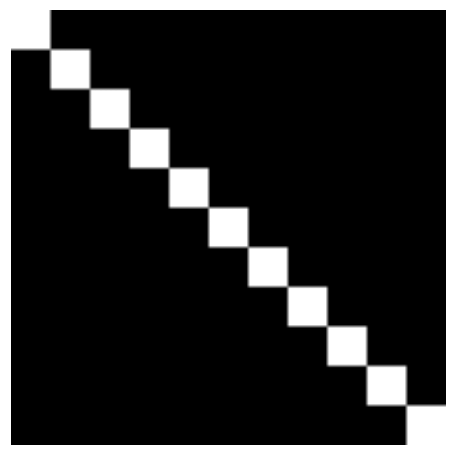

In [30]:
Image(np_same).view()

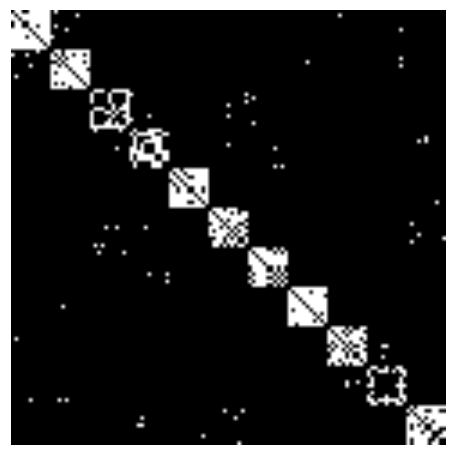

In [33]:
Image(batch_loss > 2).view()

In [34]:
print(model_path)

/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_mb/model.ckpt-31680


In [16]:
mio.export_pickle(batch_loss, '/vol/atlas/homes/jiankang/code/facenet/data/mb_matrix_1117.pkl')

### Evaluation LFW

In [10]:
def data_iterator():
    load_path = Path('/vol/atlas/homes/jiankang/code/facenet/data/lfw_160/')
    database_path = load_path
    
    img_height = 160
    img_width = 160
    n_img=2
    
    with open('/homes/yz4009/Desktop/lfw_pairs.txt') as f:
        pairs = f.readlines()
        n_fold, n_pairs = map(int, pairs[0].strip().split('\t'))
        pairs = pairs[1:]
        for fold in print_progress(range(n_fold)):
            for p in range(n_pairs):
                name,id1,id2=pairs[fold*n_pairs*2+p].strip().split('\t')
                p1 = database_path/name/('%s_%04d.png'%(name, int(id1)))
                p2 = database_path/name/('%s_%04d.png'%(name, int(id2)))
                img1 = mio.import_image(p1)
                img2 = mio.import_image(p2)
                img_all = Image(np.concatenate([img1.pixels, img2.pixels], axis=1))
                
                yield img_all, img_height, img_width, n_img, 1, [str(p1), str(p2)]

            for p in range(n_pairs, n_pairs*2):
                name1,id1, name2,id2=pairs[fold*n_pairs*2+p].strip().split('\t')
                p1 = database_path/name1/('%s_%04d.png'%(name1, int(id1)))
                p2 = database_path/name2/('%s_%04d.png'%(name2, int(id2)))
                img1 = mio.import_image(p1)
                img2 = mio.import_image(p2)
                img_all = Image(np.concatenate([img1.pixels, img2.pixels], axis=1))
                
                yield img_all, img_height, img_width, n_img, 0, [str(p1), str(p2)]

In [11]:
def evaluate(iterator):
    score = []
    
    for img_all, _,_,_, ispositive, paths_batch in iterator:
        
#         input_image = img_all.pixels_with_channels_at_back().reshape(2,160,160,3)
        input_image = load_data(paths_batch, False, False, 160)
        feature = sess.run(states['features'], feed_dict={'inputs:0':input_image})
        score.append([feature[0]-feature[1],ispositive])
    
    return score
    
scores = evaluate(data_iterator())

[====================] 100% (10/10) - done.                                     


In [12]:
def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

In [13]:
scores[0][0].shape

(512,)

In [14]:
diff, label = zip(*scores)
diff = np.array(diff).squeeze()
label = np.array(label) == 1

In [15]:
dist = np.sum(diff**2, axis=-1)

In [16]:
ankle = 5
xs = []
ys = []
for r in [10,1,0.1, 0.01]:
    x = np.clip(np.arange(ankle-r/2,ankle+r/2,r/1000),0,np.inf)
    y = list(map(lambda xi: calculate_accuracy(xi, dist, label)[2], x))
    
    xs.append(x)
    ys.append(y)
    ankle = x[np.argmax(y)]

In [17]:
x[np.argmax(y)], np.max(y)

(0.0, 0.5)

In [18]:
ankle

0.0

In [19]:
calculate_accuracy(ankle, dist, label)

(0.0, 0.0, 0.5)

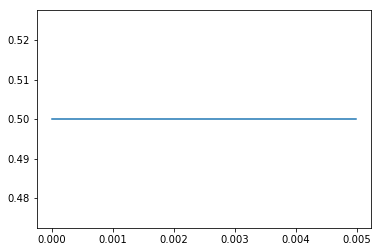

In [20]:
plt.plot(xs[-1],ys[-1])

### facenet eval

In [13]:
lfw_pairs = '/homes/yz4009/wd/gitdev/facenet/data/pairs.txt'
lfw_dir = '/vol/atlas/homes/jiankang/code/facenet/data/lfw_160/'
lfw_file_ext = 'png'
model_dir = '/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_tf/'
lfw_batch_size=100
lfw_nrof_folds=10

with tf.Graph().as_default():

    with tf.Session() as sess:
        
        net_model = recognition.FaceRecogNet()
        
        images_placeholder = tf.placeholder(tf.float32, shape=(None, 160, 160, 3), name='inputs')
        logist, states = net_model._build_network(images_placeholder)
        
        embeddings = states[0]

        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        model_path = tf.train.latest_checkpoint(model_dir)
                
        saver.restore(sess, model_path)
        print(model_path)

        # Read the file containing the pairs used for testing
        pairs = read_pairs(os.path.expanduser(lfw_pairs))

        # Get the paths for the corresponding images
        paths, actual_issame = get_paths(os.path.expanduser(lfw_dir), pairs, lfw_file_ext)

        # Load the model
        print('Model directory: %s' % model_dir)
#         meta_file, ckpt_file = get_model_filenames(os.path.expanduser(model_dir))

#         print('Metagraph file: %s' % meta_file)
#         print('Checkpoint file: %s' % ckpt_file)
#         load_model(model_dir, meta_file, ckpt_file)

        # Get input and output tensors

        image_size = images_placeholder.get_shape()[1]
        embedding_size = embeddings.get_shape()[1]

        # Run forward pass to calculate embeddings
        print('Runnning forward pass on LFW images')
        batch_size = lfw_batch_size
        nrof_images = len(paths)
        nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
        emb_array = np.zeros((nrof_images, embedding_size))
        for i in range(nrof_batches):
            start_index = i*batch_size
            end_index = min((i+1)*batch_size, nrof_images)
            paths_batch = paths[start_index:end_index]
            images = load_data(paths_batch, False, False, image_size)
            feed_dict = {images_placeholder:images}
            emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)

        tpr, fpr, accuracy, val, val_std, far = evaluate(emb_array,
            actual_issame, nrof_folds=lfw_nrof_folds)

        print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
        print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

        auc = metrics.auc(fpr, tpr)
        print('Area Under Curve (AUC): %1.3f' % auc)
        eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
        print('Equal Error Rate (EER): %1.3f' % eer)



INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_tf/model.ckpt-40000
/homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_tf/model.ckpt-40000
Model directory: /homes/yz4009/wd/gitdev/TFNet/ckpt/face/train/train_face_rec_tf/
Runnning forward pass on LFW images
Accuracy: 0.906+-0.021
Validation rate: 0.47767+-0.05496 @ FAR=0.00100
Area Under Curve (AUC): 0.969
Equal Error Rate (EER): 0.091


In [ ]:
np.